In [3]:
!pip install tensorflow matplotlib seaborn scikit-learn

In [28]:
import os, shutil, pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [24]:
import kagglehub
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Path to dataset files: /kaggle/input/microsoft-catsvsdogs-dataset


In [25]:
import os, shutil, pathlib
from sklearn.model_selection import train_test_split

# Path where kagglehub saved dataset
dataset_path = pathlib.Path(path) / "PetImages"

# New dataset structure
base_dir = pathlib.Path("dataset")
train_dir = base_dir / "training_set"
test_dir = base_dir / "test_set"

for folder in [train_dir, test_dir]:
    (folder / "cats").mkdir(parents=True, exist_ok=True)
    (folder / "dogs").mkdir(parents=True, exist_ok=True)

# Get cat and dog image paths
cat_images = [str(dataset_path / "Cat" / f) for f in os.listdir(dataset_path / "Cat") if f.endswith(".jpg")]
dog_images = [str(dataset_path / "Dog" / f) for f in os.listdir(dataset_path / "Dog") if f.endswith(".jpg")]

# Train/test split (80% train, 20% test)
cat_train, cat_test = train_test_split(cat_images, test_size=0.2, random_state=42)
dog_train, dog_test = train_test_split(dog_images, test_size=0.2, random_state=42)

# Move files
def copy_files(file_list, dest_folder):
    for f in file_list:
        try:
            shutil.copy(f, dest_folder)
        except:
            pass  # skip corrupted images

copy_files(cat_train, train_dir / "cats")
copy_files(dog_train, train_dir / "dogs")
copy_files(cat_test, test_dir / "cats")
copy_files(dog_test, test_dir / "dogs")


In [29]:
print("Train cats:", len(os.listdir(train_dir / "cats")))
print("Train dogs:", len(os.listdir(train_dir / "dogs")))
print("Test cats:", len(os.listdir(test_dir / "cats")))
print("Test dogs:", len(os.listdir(test_dir / "dogs")))


Train cats: 10000
Train dogs: 10000
Test cats: 2500
Test dogs: 2500


In [31]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
import os
from PIL import Image

def clean_dataset(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)  # Try opening the file
                img.verify()  # Verify it's an image
            except Exception as e:
                print(f"Removing corrupted/non-image file: {file_path}")
                os.remove(file_path)

# Clean training and test sets
clean_dataset("dataset/training_set")
clean_dataset("dataset/test_set")


Removing corrupted/non-image file: dataset/training_set/cats/666.jpg
Removing corrupted/non-image file: dataset/training_set/dogs/11702.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [37]:
train_set = train_datagen.flow_from_directory(
    "dataset/training_set",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

test_set = test_datagen.flow_from_directory(
    "dataset/test_set",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)


Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [38]:
print("Training classes:", train_set.class_indices)
print("Test classes:", test_set.class_indices)


Training classes: {'cats': 0, 'dogs': 1}
Test classes: {'cats': 0, 'dogs': 1}


In [39]:
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=10
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 587s 938ms/step - accuracy: 0.7129 - loss: 0.5643 - val_accuracy: 0.7420 - val_loss: 0.5228
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 586s 938ms/step - accuracy: 0.7482 - loss: 0.5104 - val_accuracy: 0.7806 - val_loss: 0.4624
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 581s 929ms/step - accuracy: 0.7744 - loss: 0.4760 - val_accuracy: 0.7798 - val_loss: 0.4697
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 588s 940ms/step - accuracy: 0.7920 - loss: 0.4460 - val_accuracy: 0.7986 - val_loss: 0.4315
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 581s 930ms/step - accuracy: 0.7997 - loss: 0.4321 - val_accuracy: 0.8110 - val_loss: 0.4216
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 584s 935ms/step - accuracy: 0.8123 - loss: 0.4101 - val_accuracy: 0.8114 - val_loss: 0.4140
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 588s 940ms/step - accuracy: 0.8182 - loss: 0.4043 - val_accuracy: 0.8058 - val_loss: 0.4229
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 586s 937ms/step - accuracy: 0.8282 -

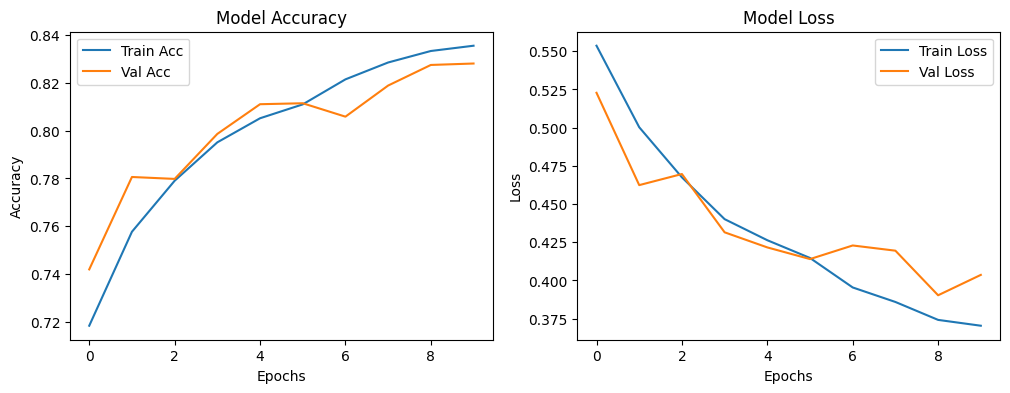

In [40]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step


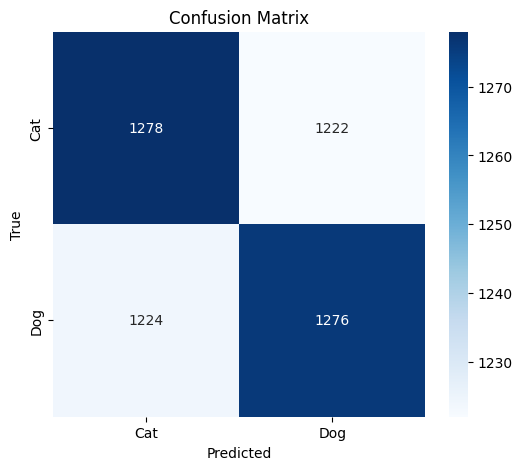

In [41]:
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [42]:
print(classification_report(y_true, y_pred, target_names=['Cat','Dog']))

              precision    recall  f1-score   support

         Cat       0.51      0.51      0.51      2500
         Dog       0.51      0.51      0.51      2500

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000

